In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import classification_model_evaluation as model_eval

In [4]:
# load base ResNet50 CNN previously trained on ImageNet dataset
# specify 'include_top = False' to allow for adding additional layers to the model
# specify shape of input images - very important! ResNet50 was trained on images of size (224, 224, 3)
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

In [6]:
# Freeze convolutional layers of ResNet50 model
for layer in base_model.layers:
    layer.trainable = False
    
# Define model layers/structure
x = base_model.output  # output from base model (minus top layer)
x = Flatten()(x)  # flatten convolution tensor output - turns into useable array dimensions for prediction
y_predict = Dense(10, activation = 'softmax')(x)  # final prediction layer (logistic regression)

# Compile model for use (slow learning rate used here with multiclass loss function)
model = Model(inputs = base_model.input, outputs = y_predict)  # defines base model input and prediction layer output
model.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])  # compiles model for fitting

In [63]:
# summary of model layers
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [64]:
# test model prediction on a sample image
img_path = 'data/River/River_1.jpg'
img = image.load_img(img_path, target_size = (64, 64))  # loads image from file
im = image.img_to_array(img)  # converts image to Numpy array
im = np.expand_dims(im, axis = 0)  # adds an extra dimension to the front to accomodate many images (now 4D)
im = preprocess_input(im)  # preprocess image (mean center, normalize) to match style of ImageNet training data 

im_pred = model.predict(im)  # generates prediction which is array with probabilities of each class
im_pred

array([[1.32112508e-03, 1.42744195e-03, 5.77977225e-05, 1.35834068e-01,
        7.04559445e-01, 3.04689724e-03, 3.14541422e-02, 2.10973877e-03,
        1.07550286e-01, 1.26391212e-02]], dtype=float32)

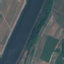

In [65]:
img

In [66]:
# image directories
os.listdir('data/')

['River',
 'Industrial',
 'AnnualCrop',
 'PermanentCrop',
 'SeaLake',
 'Highway',
 'Residential',
 'HerbaceousVegetation',
 'Forest',
 'Pasture']

In [7]:
img_path = 'data/'

def compile_images_keras(path, local = True):
    """
    Loads images from specified subdirectories, converts them to arrays, preprocesses them, 
    and compiles them into one array for Keras model fitting. Also returns labels as array;
    the labels here are the names of the subdirectories. Images have not been previously 
    split into training and test. 
    
    Parameters
    ----------
    path: str
        The path to the larger directory which contains the image subdirectories 
    local: boolean (default: True)
        Whether the path is to a local folder, since these may contain a '.DS_Store' file
    
    Returns
    -------
    ndarray
        Four-dimensional array containing image data
    ndarray
        One-dimensional array with labels (assumed to be subdirectory names)
    """
    
    direc_list = os.listdir(path)  # get the subdirectory list
    
    if local:
        direc_list.remove('.DS_Store')  # removes '.DS_Store' file from local directory
    
    collection = []
    labels = []
    
    for image_type in direc_list:
        for img in os.listdir(path + image_type):
            im = image.load_img(path + image_type + '/' + img, target_size = (64, 64))  # load image
            im_array = image.img_to_array(im)  # convert image to array
            im_array = preprocess_input(im_array)  # preprocess (mean-center and normalize) for ResNet compatibility
            collection.append(im_array)
            
            labels.append(image_type)  # extract subdirectory name as label
            
    return np.asarray(collection, np.float32), np.asarray(labels)

In [8]:
# compile all images into array
X_full, y_full = compile_images_keras(img_path, local = False)
X_full.shape, y_full.shape

((27000, 64, 64, 3), (27000,))

In [9]:
# train-test split 80-20
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.2, 
                                                    random_state = 423, stratify = y_full)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21600, 64, 64, 3)
(5400, 64, 64, 3)
(21600,)
(5400,)


In [11]:
# first convert labels to integer encodings
encoder = LabelEncoder().fit(y_train)
y_train_numeric = encoder.transform(y_train)
y_test_numeric = encoder.transform(y_test)

# then one-hot encode the integers for keras compatibility
y_train_binary = keras.utils.to_categorical(y_train_numeric, 10)
y_test_binary = keras.utils.to_categorical(y_test_numeric, 10)

In [72]:
batch_size = 32
epochs = 10

# fit a CNN! Here simple structure is used with 32 images per batch and 10 epochs (iterations)
model.fit(X_train, y_train_binary, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_test, y_test_binary), shuffle = True)

Train on 21600 samples, validate on 5400 samples
Epoch 1/10
21600/21600 [==============================] - 12s 535us/step - loss: 0.8863 - acc: 0.7366 - val_loss: 1.0077 - val_acc: 0.7209
Epoch 2/10
21600/21600 [==============================] - 9s 397us/step - loss: 0.4654 - acc: 0.8545 - val_loss: 0.7679 - val_acc: 0.7791
Epoch 3/10
21600/21600 [==============================] - 9s 398us/step - loss: 0.3812 - acc: 0.8785 - val_loss: 0.8245 - val_acc: 0.7683
Epoch 4/10
21600/21600 [==============================] - 9s 398us/step - loss: 0.3309 - acc: 0.8955 - val_loss: 0.7352 - val_acc: 0.7872
Epoch 5/10
21600/21600 [==============================] - 9s 396us/step - loss: 0.3007 - acc: 0.9005 - val_loss: 0.7676 - val_acc: 0.7822
Epoch 6/10
21600/21600 [==============================] - 9s 396us/step - loss: 0.2702 - acc: 0.9099 - val_loss: 0.7157 - val_acc: 0.7924
Epoch 7/10
21600/21600 [==============================] - 9s 397us/step - loss: 0.2571 - acc: 0.9146 - val_loss: 0.7177 - 

In [73]:
# calculate loss and accuracy for test set -> ~80% accuracy
score = model.evaluate(X_test, y_test_binary, verbose = 0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.6932757445617959
Test Accuracy: 0.797962962962963


In [12]:
def get_prediction_labels(model, X_test, generator = None):
    """
    Function for taking a Keras model fit to a training set and generating predictions from an 
    input test set. Predictions are converted from an array of class-wise probabilities to a 
    class label representing the most likely class. 
    
    Parameters
    ----------
    model: keras.engine.training.Model
        Keras model previously fit to training set
    X_test: ndarray
        Test set image data
    generator: keras.preprocessing.image.ImageDataGenerator (default: None)
        Image generator object if used for loading images
    
    Returns
    -------
    ndarray
        Array of class label predictions for all test set images
    """
    
    if generator:
        pred = model.predict_generator(generator.flow(X_test), steps = len(generator.flow(X_test)))
    else:
        pred = model.predict(X_test)
        
    pred_num = np.argmax(pred, axis = 1)
    
    labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 
              4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 
              8: 'River', 9: 'SeaLake'}
    
    return np.asarray([labels[i] for i in pred_num])

In [76]:
# get test set predictions for CNN
y_pred = get_prediction_labels(model, X_test)

In [77]:
accuracy_score(y_test, y_pred)

0.797962962962963

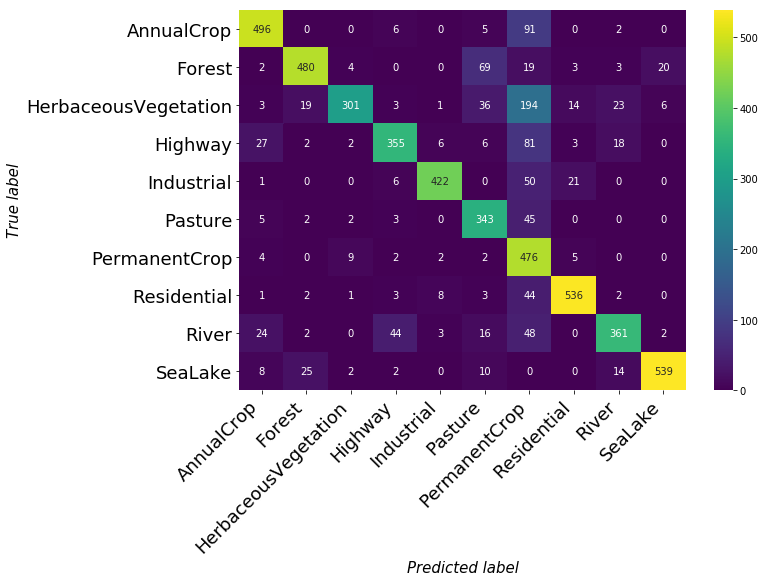

In [78]:
# generate confusion matrix for test set predictions
CNN_cm = confusion_matrix(y_test, y_pred, labels = encoder.classes_)
model_eval.print_confusion_matrix(CNN_cm, encoder.classes_)

In [81]:
# simple classification report showing precision, recall, and f1-score for each class
print(classification_report(y_test, y_pred, labels = encoder.classes_))

                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.83      0.85       600
              Forest       0.90      0.80      0.85       600
HerbaceousVegetation       0.94      0.50      0.65       600
             Highway       0.84      0.71      0.77       500
          Industrial       0.95      0.84      0.90       500
             Pasture       0.70      0.86      0.77       400
       PermanentCrop       0.45      0.95      0.61       500
         Residential       0.92      0.89      0.91       600
               River       0.85      0.72      0.78       500
             SeaLake       0.95      0.90      0.92       600

            accuracy                           0.80      5400
           macro avg       0.84      0.80      0.80      5400
        weighted avg       0.85      0.80      0.80      5400



In [55]:
# try building a more complex CNN with additional layers added before the prediction layer
x = base_model.output  # still using base ResNet50 layers
x = Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x) # 2D convolution layer
x = Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)  # Max Pooling: downsamples image by taking max value of each 2x2 pixel grid 
x = Flatten()(x)  # flatten convolution tensor output
x = Dense(1024, activation = 'relu')(x)   # add a fully-connected layer
x = Dropout(0.5)(x)  # Dropout: take random sample of nodes at each layer for each epoch (helps avoid overfitting)
y_predict = Dense(10, activation = 'softmax')(x)  # final prediction layer

model2 = Model(inputs = base_model.input, outputs = y_predict)
model2.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [56]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [93]:
batch_size = 128
epochs = 100

model2.fit(X_train, y_train_binary, batch_size = batch_size, epochs = epochs, 
           validation_data = (X_test, y_test_binary), shuffle = True)

Train on 21600 samples, validate on 5400 samples
Epoch 1/100
21600/21600 [==============================] - 8s 364us/step - loss: 2.3001 - acc: 0.1063 - val_loss: 2.2784 - val_acc: 0.1296
Epoch 2/100
21600/21600 [==============================] - 4s 204us/step - loss: 2.2695 - acc: 0.1348 - val_loss: 2.2412 - val_acc: 0.1393
Epoch 3/100
21600/21600 [==============================] - 4s 204us/step - loss: 2.2286 - acc: 0.1498 - val_loss: 2.1845 - val_acc: 0.1391
Epoch 4/100
21600/21600 [==============================] - 4s 202us/step - loss: 2.1709 - acc: 0.1852 - val_loss: 2.1088 - val_acc: 0.1880
Epoch 5/100
21600/21600 [==============================] - 4s 202us/step - loss: 2.0960 - acc: 0.2371 - val_loss: 2.0108 - val_acc: 0.2698
Epoch 6/100
21600/21600 [==============================] - 4s 201us/step - loss: 1.9906 - acc: 0.3190 - val_loss: 1.8813 - val_acc: 0.3657
Epoch 7/100
21600/21600 [==============================] - 4s 203us/step - loss: 1.8500 - acc: 0.4017 - val_loss: 1.7

In [94]:
# only improved to 81% accuracy (though overfitting did occur -> reached ~83% at epoch 66)
y_pred = get_prediction_labels(model2, X_test)
accuracy_score(y_test, y_pred)

0.8105555555555556

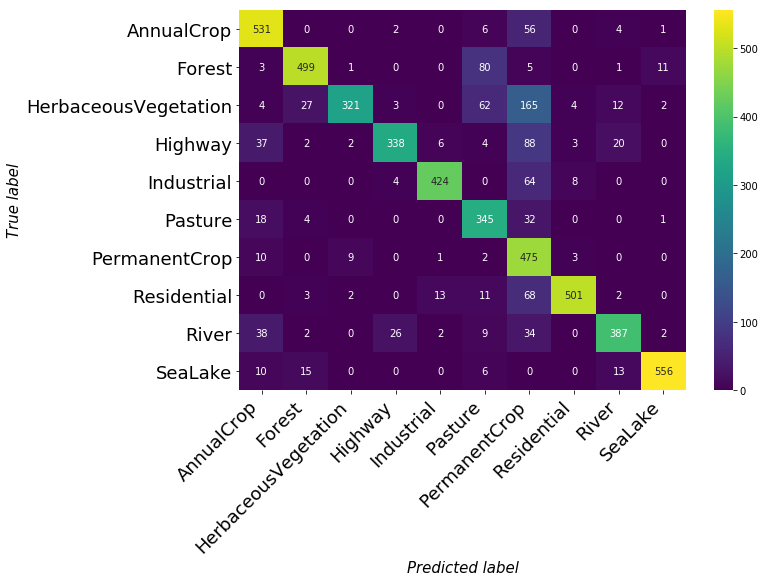

In [95]:
CNN_cm2 = confusion_matrix(y_test, y_pred, labels = encoder.classes_)
model_eval.print_confusion_matrix(CNN_cm2, encoder.classes_)

In [96]:
print(classification_report(y_test, y_pred, labels = encoder.classes_))

                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.89      0.85       600
              Forest       0.90      0.83      0.87       600
HerbaceousVegetation       0.96      0.54      0.69       600
             Highway       0.91      0.68      0.77       500
          Industrial       0.95      0.85      0.90       500
             Pasture       0.66      0.86      0.75       400
       PermanentCrop       0.48      0.95      0.64       500
         Residential       0.97      0.83      0.90       600
               River       0.88      0.77      0.82       500
             SeaLake       0.97      0.93      0.95       600

            accuracy                           0.81      5400
           macro avg       0.85      0.81      0.81      5400
        weighted avg       0.86      0.81      0.82      5400



In [97]:
# save weights for future use
model2.save_weights('CNN_weights.h5')

In [13]:
# try using image generator instead for loading images to allow for image augmentation
# generator here scales images, shears and zooms them randomly, flips them horizontally, and reserves 20% for test set
im_generator = image.ImageDataGenerator(
                                        rescale = 1.0 / 255, 
                                        shear_range = 0.2, 
                                        zoom_range = 0.2, 
                                        horizontal_flip = True, 
                                        validation_split = 0.2
                                        )

In [14]:
# use 'flow_from_directory' to create generator objects for training and test sets; model loads images in batches
# images must be in subdirectories for this to work (see documentation)
train_generator = im_generator.flow_from_directory(
                                                img_path, 
                                                target_size = (64, 64), 
                                                class_mode = 'categorical', 
                                                batch_size = 32, 
                                                shuffle = True, 
                                                seed = 423, 
                                                subset = 'training'  # pulls only training set images
                                            )
test_generator = im_generator.flow_from_directory(
                                                img_path, 
                                                target_size = (64, 64), 
                                                class_mode = 'categorical', 
                                                batch_size = 32, 
                                                shuffle = True, 
                                                seed = 423, 
                                                subset = 'validation'  # pulls test set images
                                            )

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [15]:
epochs = 10

# use 'fit_generator' to fit CNN with image generators - 'steps_per_epoch' typically # images / batch size
model.fit_generator(
                    train_generator, 
                    steps_per_epoch = len(train_generator), 
                    epochs = epochs, 
                    validation_data = test_generator, 
                    validation_steps = len(test_generator))

W0918 21:16:03.991648 139799766038272 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
675/675 [==============================] - 43s 64ms/step - loss: 0.9226 - acc: 0.7162 - val_loss: 2.9680 - val_acc: 0.1111
Epoch 2/10
675/675 [==============================] - 39s 58ms/step - loss: 0.5445 - acc: 0.8281 - val_loss: 3.2684 - val_acc: 0.1111
Epoch 3/10
675/675 [==============================] - 39s 58ms/step - loss: 0.4667 - acc: 0.8515 - val_loss: 3.4410 - val_acc: 0.1111
Epoch 4/10
675/675 [==============================] - 39s 58ms/step - loss: 0.4410 - acc: 0.8589 - val_loss: 3.5764 - val_acc: 0.1111
Epoch 5/10
675/675 [==============================] - 39s 58ms/step - loss: 0.3976 - acc: 0.8708 - val_loss: 3.7140 - val_acc: 0.1111
Epoch 6/10
675/675 [==============================] - 39s 58ms/step - loss: 0.3808 - acc: 0.8773 - val_loss: 3.8445 - val_acc: 0.1111
Epoch 7/10
675/675 [==============================] - 39s 58ms/step - loss: 0.3636 - acc: 0.8820 - val_loss: 3.9001 - val_acc: 0.1111
Epoch 8/10
675/675 [==============================] - 39s 58ms

In [30]:
# only 57% accuracy
y_pred = get_prediction_labels(model, X_test)
accuracy_score(y_test, y_pred)

0.5701851851851852

In [17]:
print(classification_report(y_test, y_pred, labels = encoder.classes_))

                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.36      0.51       600
              Forest       0.50      0.18      0.27       600
HerbaceousVegetation       0.55      0.55      0.55       600
             Highway       0.62      0.62      0.62       500
          Industrial       0.51      0.96      0.66       500
             Pasture       0.46      0.76      0.57       400
       PermanentCrop       0.30      0.65      0.41       500
         Residential       0.81      0.82      0.81       600
               River       0.93      0.25      0.40       500
             SeaLake       0.97      0.66      0.78       600

            accuracy                           0.57      5400
           macro avg       0.65      0.58      0.56      5400
        weighted avg       0.66      0.57      0.56      5400



In [19]:
# try different image generator - now with featurewise centering and scaling, rotation, and width/height shifting
im_generator2 = image.ImageDataGenerator(
                                        featurewise_center = True, 
                                        featurewise_std_normalization = True,
                                        rotation_range = 20,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        shear_range = 0.2, 
                                        zoom_range = 0.2, 
                                        horizontal_flip = True
                                        )

im_generator2.fit(X_train)

In [22]:
# change CNN model structure
x = base_model.output
x = GlobalAveragePooling2D()(x)  # condenses output like 'Flatten' but uses average pooling across all pixels
x = Dense(1024, activation = 'relu')(x)  # fully-connected layer
y_predict = Dense(10, activation = 'softmax')(x)  # prediction layer

model3 = Model(inputs = base_model.input, outputs = y_predict)
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy')  # different optimizer

In [23]:
epochs = 5
batch_size = 32

model3.fit_generator(im_generator2.flow(X_train, y_train_binary, batch_size = batch_size), 
                     steps_per_epoch = len(X_train)/batch_size, epochs = epochs)

Epoch 1/5
675/675 [==============================] - 28s 41ms/step - loss: 0.6961
Epoch 2/5
675/675 [==============================] - 26s 38ms/step - loss: 0.5110
Epoch 3/5
675/675 [==============================] - 26s 39ms/step - loss: 0.4897
Epoch 4/5
675/675 [==============================] - 26s 38ms/step - loss: 0.4822
Epoch 5/5
675/675 [==============================] - 26s 38ms/step - loss: 0.4764


In [47]:
# do I need to fit generator object to test set before making predictions?
y_pred = get_prediction_labels(model3, X_test, generator = im_generator2)
accuracy_score(y_test, y_pred)

0.1111111111111111

In [48]:
# evidently not
y_pred = get_prediction_labels(model3, X_test)
accuracy_score(y_test, y_pred)

0.6896296296296296

In [27]:
# model layers
for i, layer in enumerate(model3.layers):
    print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_50
5 pool1_pad
6 max_pooling2d_2
7 res2a_branch2a
8 bn2a_branch2a
9 activation_51
10 res2a_branch2b
11 bn2a_branch2b
12 activation_52
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_17
18 activation_53
19 res2b_branch2a
20 bn2b_branch2a
21 activation_54
22 res2b_branch2b
23 bn2b_branch2b
24 activation_55
25 res2b_branch2c
26 bn2b_branch2c
27 add_18
28 activation_56
29 res2c_branch2a
30 bn2c_branch2a
31 activation_57
32 res2c_branch2b
33 bn2c_branch2b
34 activation_58
35 res2c_branch2c
36 bn2c_branch2c
37 add_19
38 activation_59
39 res3a_branch2a
40 bn3a_branch2a
41 activation_60
42 res3a_branch2b
43 bn3a_branch2b
44 activation_61
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_20
50 activation_62
51 res3b_branch2a
52 bn3b_branch2a
53 activation_63
54 res3b_branch2b
55 bn3b_branch2b
56 activation_64
57 res3b_branch2c
58 bn3b_branch2c
59 add_21
60 activation_65
61 res3c_branch2a
62

In [49]:
# try 'fine-tuning' the last two ResNet50 branches -> make them trainable for this
# allows back propagation to update ('tune') these layers for the images at hand
for layer in model3.layers[:168]:
    layer.trainable = False  # keep other branches frozen
for layer in model3.layers[168:]:
    layer.trainable = True

# have to recompile after doing this!
model3.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), loss = 'categorical_crossentropy')

In [50]:
epochs = 10
batch_size = 32

model3.fit_generator(im_generator2.flow(X_train, y_train_binary, batch_size = batch_size), 
                     steps_per_epoch = len(X_train)/batch_size, epochs = epochs)

Epoch 1/10
675/675 [==============================] - 28s 42ms/step - loss: 0.3883
Epoch 2/10
675/675 [==============================] - 26s 38ms/step - loss: 0.3621
Epoch 3/10
675/675 [==============================] - 26s 39ms/step - loss: 0.3402
Epoch 4/10
675/675 [==============================] - 26s 39ms/step - loss: 0.3478
Epoch 5/10
675/675 [==============================] - 26s 39ms/step - loss: 0.3160
Epoch 6/10
675/675 [==============================] - 26s 39ms/step - loss: 0.3145
Epoch 7/10
675/675 [==============================] - 26s 39ms/step - loss: 0.2936
Epoch 8/10
675/675 [==============================] - 26s 39ms/step - loss: 0.2963
Epoch 9/10
675/675 [==============================] - 26s 38ms/step - loss: 0.2911
Epoch 10/10
675/675 [==============================] - 26s 39ms/step - loss: 0.2895


In [52]:
# no significant accuracy improvement
y_pred = get_prediction_labels(model3, X_test)
accuracy_score(y_test, y_pred)

0.6753703703703704

In [61]:
# what if we try this for the original model structure?
for layer in model.layers[:168]:
    layer.trainable = False
for layer in model.layers[168:]:
    layer.trainable = True
    
model.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [62]:
batch_size = 32
epochs = 10

model.fit(X_train, y_train_binary, batch_size = batch_size, epochs = epochs, 
           validation_data = (X_test, y_test_binary), shuffle = True)

Train on 21600 samples, validate on 5400 samples
Epoch 1/10
21600/21600 [==============================] - 13s 613us/step - loss: 0.4797 - acc: 0.8467 - val_loss: 0.9144 - val_acc: 0.7630
Epoch 2/10
21600/21600 [==============================] - 10s 450us/step - loss: 0.3344 - acc: 0.8918 - val_loss: 0.7204 - val_acc: 0.8007
Epoch 3/10
21600/21600 [==============================] - 10s 449us/step - loss: 0.2755 - acc: 0.9074 - val_loss: 0.7686 - val_acc: 0.7915
Epoch 4/10
21600/21600 [==============================] - 10s 448us/step - loss: 0.2459 - acc: 0.9188 - val_loss: 0.7229 - val_acc: 0.8019
Epoch 5/10
21600/21600 [==============================] - 10s 449us/step - loss: 0.2264 - acc: 0.9232 - val_loss: 0.6783 - val_acc: 0.8130
Epoch 6/10
21600/21600 [==============================] - 10s 449us/step - loss: 0.2140 - acc: 0.9275 - val_loss: 0.6237 - val_acc: 0.8276
Epoch 7/10
21600/21600 [==============================] - 10s 449us/step - loss: 0.1935 - acc: 0.9342 - val_loss: 0.6

In [63]:
# minimal improvement
y_pred = get_prediction_labels(model, X_test)
accuracy_score(y_test, y_pred)

0.8181481481481482

In [64]:
# try making all ResNet layers tunable
for layer in model2.layers:
    layer.trainable = True

model2.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [65]:
batch_size = 32
epochs = 80

model2.fit(X_train, y_train_binary, batch_size = batch_size, epochs = epochs, 
           validation_data = (X_test, y_test_binary), shuffle = True)

Train on 21600 samples, validate on 5400 samples
Epoch 1/80
21600/21600 [==============================] - 46s 2ms/step - loss: 0.8771 - acc: 0.7336 - val_loss: 0.3893 - val_acc: 0.9039
Epoch 2/80
21600/21600 [==============================] - 37s 2ms/step - loss: 0.3943 - acc: 0.8790 - val_loss: 0.1980 - val_acc: 0.9419
Epoch 3/80
21600/21600 [==============================] - 37s 2ms/step - loss: 0.2512 - acc: 0.9228 - val_loss: 0.1635 - val_acc: 0.9472
Epoch 4/80
21600/21600 [==============================] - 37s 2ms/step - loss: 0.1971 - acc: 0.9361 - val_loss: 0.1487 - val_acc: 0.9526
Epoch 5/80
21600/21600 [==============================] - 37s 2ms/step - loss: 0.1605 - acc: 0.9472 - val_loss: 0.1338 - val_acc: 0.9587
Epoch 6/80
21600/21600 [==============================] - 37s 2ms/step - loss: 0.1360 - acc: 0.9558 - val_loss: 0.1298 - val_acc: 0.9607
Epoch 7/80
21600/21600 [==============================] - 37s 2ms/step - loss: 0.1165 - acc: 0.9636 - val_loss: 0.1263 - val_acc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21600/21600 [==============================] - 34s 2ms/step - loss: 0.0061 - acc: 0.9984 - val_loss: 0.1469 - val_acc: 0.9683
Epoch 59/80
21600/21600 [==============================] - 34s 2ms/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.1473 - val_acc: 0.9674
Epoch 60/80
21600/21600 [==============================] - 35s 2ms/step - loss: 0.0046 - acc: 0.9984 - val_loss: 0.1492 - val_acc: 0.9680
Epoch 61/80
21600/21600 [==============================] - 34s 2ms/step - loss: 0.0061 - acc: 0.9981 - val_loss: 0.1504 - val_acc: 0.9696
Epoch 62/80
21600/21600 [==============================] - 34s 2ms/step - loss: 0.0043 - acc: 0.9987 - val_loss: 0.1547 - val_acc: 0.9672
Epoch 63/80
21600/21600 [==============================] - 35s 2ms/step - loss: 0.0052 - acc: 0.9984 - val_loss: 0.1578 - val_acc: 0.9665
Epoch 64/80
21600/21600 [==============================] - 35s 2ms/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.1512 - val_acc: 0.9676
Epoch 65/80
21600/21600 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21600/21600 [==============================] - 35s 2ms/step - loss: 0.0042 - acc: 0.9988 - val_loss: 0.1479 - val_acc: 0.9683
Epoch 78/80
21600/21600 [==============================] - 35s 2ms/step - loss: 0.0036 - acc: 0.9989 - val_loss: 0.1537 - val_acc: 0.9693
Epoch 79/80
21600/21600 [==============================] - 34s 2ms/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.1492 - val_acc: 0.9687
Epoch 80/80
21600/21600 [==============================] - 34s 2ms/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.1460 - val_acc: 0.9683


In [66]:
# now we're talking. 97% accuracy!
y_pred = get_prediction_labels(model2, X_test)
accuracy_score(y_test, y_pred)

0.9683333333333334

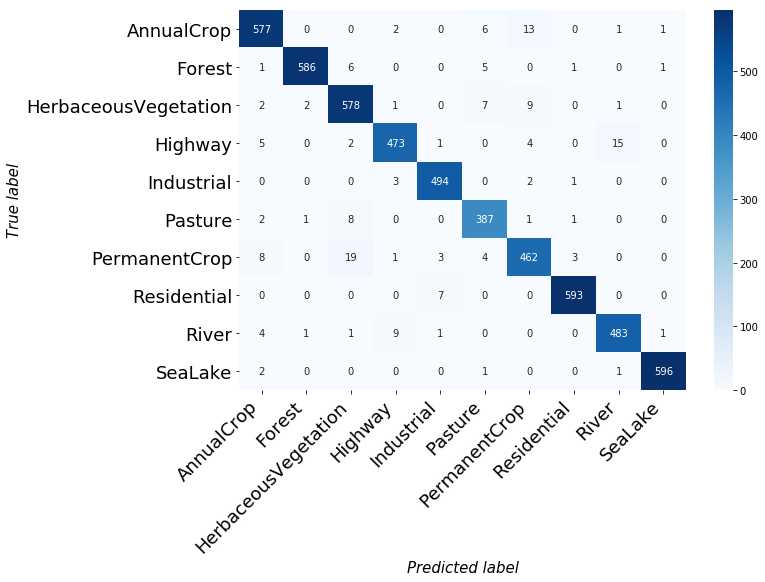

In [67]:
CNN_cm3 = confusion_matrix(y_test, y_pred, labels = encoder.classes_)
model_eval.print_confusion_matrix(CNN_cm3, encoder.classes_)

In [68]:
print(classification_report(y_test, y_pred, labels = encoder.classes_))

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.96      0.96       600
              Forest       0.99      0.98      0.98       600
HerbaceousVegetation       0.94      0.96      0.95       600
             Highway       0.97      0.95      0.96       500
          Industrial       0.98      0.99      0.98       500
             Pasture       0.94      0.97      0.96       400
       PermanentCrop       0.94      0.92      0.93       500
         Residential       0.99      0.99      0.99       600
               River       0.96      0.97      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



In [14]:
# slightly different model structure
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
y_predict = Dense(10, activation = 'softmax')(x)

model4 = Model(inputs = base_model.input, outputs = y_predict)

In [15]:
# make all layers tunable
for layer in model4.layers:
    layer.trainable = True

model4.compile(optimizer = SGD(lr = 0.0001, momentum = 0.9), 
               loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
batch_size = 32
epochs = 20

model4.fit(X_train, y_train_binary, batch_size = batch_size, epochs = epochs, 
           validation_data = (X_test, y_test_binary), shuffle = True)

W0919 19:56:19.308046 140572046759680 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 21600 samples, validate on 5400 samples
Epoch 1/20
21600/21600 [==============================] - 46s 2ms/step - loss: 0.9451 - acc: 0.7338 - val_loss: 0.4460 - val_acc: 0.9104
Epoch 2/20
21600/21600 [==============================] - 35s 2ms/step - loss: 0.3312 - acc: 0.8975 - val_loss: 0.1708 - val_acc: 0.9463
Epoch 3/20
21600/21600 [==============================] - 35s 2ms/step - loss: 0.2363 - acc: 0.9260 - val_loss: 0.1396 - val_acc: 0.9574
Epoch 4/20
21600/21600 [==============================] - 35s 2ms/step - loss: 0.1837 - acc: 0.9416 - val_loss: 0.1245 - val_acc: 0.9617
Epoch 5/20
21600/21600 [==============================] - 34s 2ms/step - loss: 0.1576 - acc: 0.9499 - val_loss: 0.1230 - val_acc: 0.9633
Epoch 6/20
21600/21600 [==============================] - 33s 2ms/step - loss: 0.1255 - acc: 0.9597 - val_loss: 0.1169 - val_acc: 0.9644
Epoch 7/20
21600/21600 [==============================] - 33s 2ms/step - loss: 0.1109 - acc: 0.9643 - val_loss: 0.1199 - val_acc:

In [17]:
# still ~97% accuracy. Not bad!
y_pred = get_prediction_labels(model4, X_test)
accuracy_score(y_test, y_pred)

0.9685185185185186

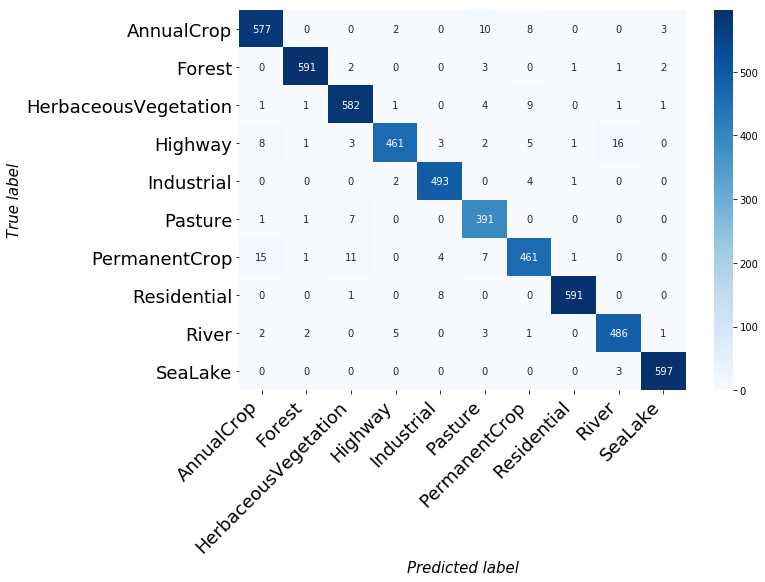

In [19]:
CNN_cm4 = confusion_matrix(y_test, y_pred, labels = encoder.classes_)
model_eval.print_confusion_matrix(CNN_cm4, encoder.classes_, file = 'CNN_cm.png')

In [20]:
print(classification_report(y_test, y_pred, labels = encoder.classes_))

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.96      0.96       600
              Forest       0.99      0.98      0.99       600
HerbaceousVegetation       0.96      0.97      0.97       600
             Highway       0.98      0.92      0.95       500
          Industrial       0.97      0.99      0.98       500
             Pasture       0.93      0.98      0.95       400
       PermanentCrop       0.94      0.92      0.93       500
         Residential       0.99      0.98      0.99       600
               River       0.96      0.97      0.97       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



In [21]:
model4.save_weights('CNN_weights.h5')